# lets build a name generator, but this time use more than one previous character as context

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pull text file
names = open('names.txt').read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# create vocab list
vocab = sorted(list(set(''.join(names))))

# create tokenizer encoder
stoi = {}
# make the model hallucinate a start token so that we can propmt it to generate a name
# stoi is String TO Integer
stoi['.'] = 0
stoi.update({s:i+1 for i, s in enumerate(vocab)})

# create tokenizer decoder
# itos is Integer TO String
itos = {}
# make the model hallucinate an end token so that it knows when to end the name during generation
itos[0] = '.'
itos.update({i+1:s for i, s in enumerate(vocab)})
print(stoi)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [4]:
# how many characters we're using as context to predict the next --> block size
block_size = 3
# create dataset
X, Y = [], []
for name in names[:5]: # iterate over all names in dataset
    # start with block size number of starting tokens to trigger the first character
    context = [0] * block_size
    # hallucinate an end token
    name += '.'
    for ch in name: # iterate over each character
        X.append(context)
        Y.append(stoi[ch])
        # print(f"context: {''.join([itos[i] for i in context])} --> {ch}")
        # left shift context and append next character
        context = context[1:] + [stoi[ch]]
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
print(X.shape, Y.shape)

torch.Size([32, 3]) torch.Size([32])


### what does it mean when embedding (emb) matrix is of shape: [32, 3, 2]
### there are 32 training examples, each of which has three characters (block size). and each character is represented (squashed down) to 2 dimensions

### one hot encoding dot product with a matrix is equivalent to plucking out a single row. this can be thought of a first layer of the network where we obtain the embeddings for each tokenized vector. for now we'll settle with pytorch slicing which also allows this 

In [33]:
# initialize params
C = torch.randn((27, 2))
W1 = torch.randn((6, 100)) # 6 because we give 3 characters at a time, and each has 2 numbers to represent them. so 6 in all
b1 = torch.randn(100)
W2 = torch.randn((100, 27))
b2 = torch.randn(27)
parameters = [W1, b1, W2, b2, C]
sum(p.nelement() for p in parameters)

3481

In [34]:
for p in parameters:
    p.requires_grad = True

Epoch: 0, loss: 21.739755630493164
Epoch: 100, loss: 0.510592520236969
Epoch: 200, loss: 0.3175155818462372
Epoch: 300, loss: 0.2780958414077759
Epoch: 400, loss: 0.26773133873939514
Epoch: 500, loss: 0.26303350925445557
Epoch: 600, loss: 0.2603802978992462
Epoch: 700, loss: 0.25868600606918335
Epoch: 800, loss: 0.25751498341560364
Epoch: 900, loss: 0.25665971636772156


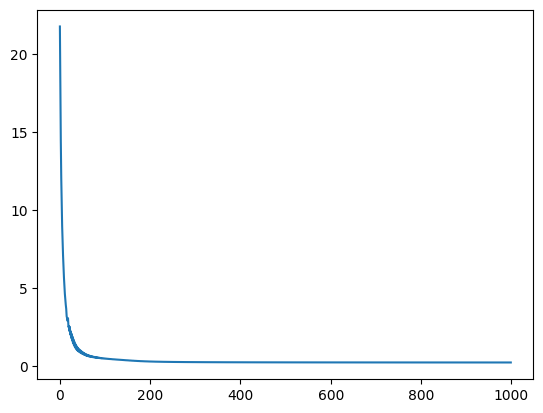

In [35]:
losses = []
epochs = 1000
for i in range(epochs):
    # forward pass
    emb = C[X]
    # layer 1
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
    # layer 2
    logits = h @ W2 + b2
    # probs = torch.softmax(logits, 1) # softmax along dimension 1
    # loss = -torch.log(probs[torch.arange(X.shape[0]), Y]).mean() # calculate NLL for all X.shape[0] examples (akin to batch size)
    loss = F.cross_entropy(logits, Y) # does the same thing the above two lines does
    # backprop
    for p in parameters:
        p.grad = None
    loss.backward()
    # gradient update
    for p in parameters:
        p.data += -0.1*p.grad
    losses.append(loss.item())
    if i % 100 == 0:
        print(f"Epoch: {i}, loss: {loss.item()}")

plt.plot(losses)

In [ ]:
# torch.cat((emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]), 1).shape # --> this doesn't work when we have a bigger batch size
# torch.cat(torch.unbind(emb, 1), 1).shape # --> this works better, we unbind the 1st dimension and then concatenate the 1st dimension to match 6 with 6 from the next layer


# the addition between emb.w1 and b works correctly without additional editing because:
emb.w1 shape: 32, 100
b1 shape:         100
pytorch broadcasting rules matches the right dim, then fills the left ones with 1 if its missing, and then 1 is broadcasted to match whatever is above it
b1 broadcasted shape: 1, 100 to 32, 100